In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# File Objective: data preparation for training

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [ ]:
GLOBAL_FLOAT_PRECISION_NUMPY = np.float64

In [ ]:
survey_data_folder_path = r'/content/drive/MyDrive/Survey_Data'
columns = ["APD", "CA+", "CA-", "Trigger"]

In [ ]:
experiment_id = '011_001'
master_run = '15795'

In [ ]:
data0_file_path = os.path.join(survey_data_folder_path, experiment_id, "raw_data", master_run, 'data0.pkl')
data1_file_path = os.path.join(survey_data_folder_path, experiment_id, "raw_data", master_run, 'data1.pkl')
data2_file_path = os.path.join(survey_data_folder_path, experiment_id, "raw_data", master_run, 'data2.pkl')
data0 = pd.DataFrame(pd.read_pickle(data0_file_path), columns=columns)
data1 = pd.DataFrame(pd.read_pickle(data1_file_path), columns=columns)
data2 = pd.DataFrame(pd.read_pickle(data2_file_path), columns=columns)

In [ ]:
print(data0.head())

    APD   CA+    CA-  Trigger
0  1821  5888  14390      919
1  1910  3964  14382      955
2  1930  6833  14341      947
3  1966  5469  14434      927
4  1785  6721  14260      923


In [ ]:
# Given a dataframe -> returns a list of windows around raman pulses
def get_raman_pulse_windows(data, window_size=1000, step_size=50):
	# find windows where max trigger value > 20000, and highlight on the plot
	trigger_values = data['Trigger']

	maximum_values = [trigger_values.iloc[i:i+window_size].max() for i in range(0, len(trigger_values) - window_size, step_size)]
	maximum_values_df = pd.DataFrame(maximum_values, columns=['Max Trigger Value'])

	# Add the starting index of the current window
	maximum_values_df['Starting Index'] = maximum_values_df.index * step_size

	# Filter out windows where max trigger value > 20000
	high_trigger_windows = maximum_values_df[maximum_values_df['Max Trigger Value'] > 20000]

	# combine all overlapping windows, eg: [1, 2], [2, 3] -> [1, 3]
	current_window_begin = -1
	current_window_end = -1
	combined_windows = []
	for i in range(len(high_trigger_windows)):
		if i == 0:
			current_window_begin = high_trigger_windows['Starting Index'].iloc[i]
			current_window_end = high_trigger_windows['Starting Index'].iloc[i] + window_size
		else:
			if high_trigger_windows['Starting Index'].iloc[i] <= current_window_end:
				current_window_end = high_trigger_windows['Starting Index'].iloc[i] + window_size
			else:
				combined_windows.append((current_window_begin, current_window_end))
				current_window_begin = high_trigger_windows['Starting Index'].iloc[i]
				current_window_end = high_trigger_windows['Starting Index'].iloc[i] + window_size
		if i == len(high_trigger_windows) - 1:
			combined_windows.append((current_window_begin, current_window_end))

	# filter out windows at even indices
	combined_windows = combined_windows[0::2]
	return combined_windows

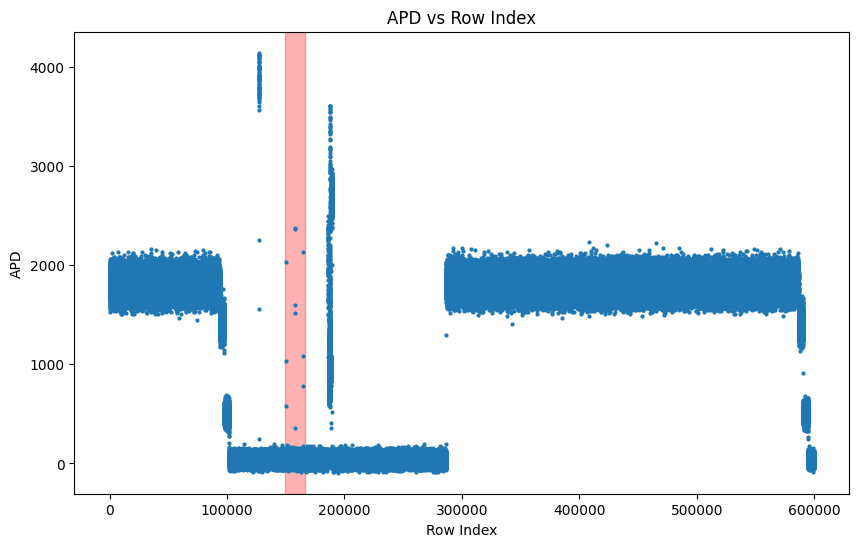

In [ ]:
test_subset = data0.iloc[0:int(6e5)]
test_windows = get_raman_pulse_windows(test_subset)

# plot
plt.figure(figsize=(10, 6))
plt.plot(test_subset.index, test_subset['APD'], 'o', markersize=2)
plt.xlabel('Row Index')
plt.ylabel('APD')
plt.title('APD vs Row Index')

# Highlight raman windows
for window in test_windows:
	plt.axvspan(window[0], window[1], color='red', alpha=0.3)

plt.show()

In [ ]:
# count number of windows across all data files
window_size = 10000
step_size = 5000
combined_windows_data0 = get_raman_pulse_windows(data0, window_size, step_size)
combined_windows_data1 = get_raman_pulse_windows(data1, window_size, step_size)
combined_windows_data2 = get_raman_pulse_windows(data2, window_size, step_size)

print(f'total number of windows in data0: {len(combined_windows_data0)}')
print(f'total number of windows in data1: {len(combined_windows_data1)}')
print(f'total number of windows in data2: {len(combined_windows_data2)}')
print(f'total number of windows across all data files: {len(combined_windows_data0) + len(combined_windows_data1) + len(combined_windows_data2)}')

total number of windows in data0: 64
total number of windows in data1: 64
total number of windows in data2: 30
total number of windows across all data files: 158


# Derive statistics for CA+ and CA-

In [ ]:
stat_columns = [
    'CA+_mean', 'CA+_std_dev', 'CA+_percentile_0', 'CA+_percentile_10', 'CA+_percentile_20',
    'CA+_percentile_30', 'CA+_percentile_40', 'CA+_percentile_50', 'CA+_percentile_60', 'CA+_percentile_70',
    'CA+_percentile_80', 'CA+_percentile_90', 'CA+_percentile_100', 'CA-_mean', 'CA-_std_dev', 'CA-_percentile_0', 'CA-_percentile_10', 'CA-_percentile_20', 'CA-_percentile_30',
    'CA-_percentile_40', 'CA-_percentile_50', 'CA-_percentile_60', 'CA-_percentile_70', 'CA-_percentile_80',
    'CA-_percentile_90', 'CA-_percentile_100'
]

In [ ]:
# Given a list of values, returns a list [mean, geometric_mean or 0, std. deviation, 0th percentile, 10th percentile... 100th percentile]
def get_stats(values):
	values = np.array(values, dtype=GLOBAL_FLOAT_PRECISION_NUMPY)
	stats = []
	stats.append(np.mean(values))
	stats.append(np.std(values))
	for i in range(0, 101, 10):
		stats.append(np.percentile(values, i))
	return stats

In [ ]:
# Given a dataframe and a list of raman windows, returns a list of stats for CA+ and CA- each window
def get_window_stats_from_dataframe(data, windows):
	window_stats = []
	for window in windows:
		window_data_ca_plus = data['CA+'].iloc[window[0]:window[1]]
		window_data_ca_minus = data['CA-'].iloc[window[0]:window[1]]
		ca_plus_ca_minus_combined_stats = get_stats(window_data_ca_plus)
		ca_plus_ca_minus_combined_stats.extend(get_stats(window_data_ca_minus))
		window_stats.append(ca_plus_ca_minus_combined_stats)
	stats_df = pd.DataFrame(window_stats, columns=stat_columns)
	return stats_df

In [ ]:
test_statistics = get_window_stats_from_dataframe(test_subset, test_windows)
print(test_statistics.head())

      CA+_mean  CA+_std_dev  CA+_percentile_0  CA+_percentile_10  \
0  4271.655457  2025.222384           -3526.0             1709.6   

   CA+_percentile_20  CA+_percentile_30  CA+_percentile_40  CA+_percentile_50  \
0             2575.0             3207.0             3755.0             4282.0   

   CA+_percentile_60  CA+_percentile_70  ...  CA-_percentile_10  \
0             4793.0             5312.0  ...              307.0   

   CA-_percentile_20  CA-_percentile_30  CA-_percentile_40  CA-_percentile_50  \
0              339.0              360.0              380.0              400.0   

   CA-_percentile_60  CA-_percentile_70  CA-_percentile_80  CA-_percentile_90  \
0              416.0              436.0              461.0              493.0   

   CA-_percentile_100  
0             32767.0  

[1 rows x 26 columns]


# Pick out relevant columns from the csv

In [ ]:
# Given a csv file path, returns a datafram only containing the columns: master_run_number, var1, fraction
dtype_spec = {
    'var1': GLOBAL_FLOAT_PRECISION_NUMPY,
    'fraction': GLOBAL_FLOAT_PRECISION_NUMPY,
    'master_run': 'int32'
}

def get_data_from_csv(csv_file_path):
	df = pd.read_csv(csv_file_path, dtype=dtype_spec)
	df = df[['master_run_number', 'var1', 'fraction']]
	df = df.rename(columns={'var1': 'chirp_rate'})
	# convert chirp rate from MHz to Hz
	df['chirp_rate'] = df['chirp_rate'] * 1e6
	return df

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sample_csv_file_path = r'/content/drive/MyDrive/Survey_Data/011_001/chirp_down/fringes_data.csv'
sample_data = get_data_from_csv(sample_csv_file_path)

print(sample_data.shape)
print(sample_data.head())

(79, 3)
   master_run_number  chirp_rate  fraction
0              15795 -25094730.0  0.592062
1              15795 -25093400.0  0.558413
2              15795 -25093120.0  0.489731
3              15795 -25091720.0  0.452956
4              15795 -25095360.0  0.525355


## Calculating Contrast, Fringe Offset and G0 values for a (master_run, chirp_direction) pair

In [ ]:
# I'm not sure of the calculations here, copied from the original code
# constants for evaluation: keff, bigT
speed_of_light_in_vacuum = GLOBAL_FLOAT_PRECISION_NUMPY(299792458)
f1 = GLOBAL_FLOAT_PRECISION_NUMPY(384.2304844685e12) - 72.9113e6 - 2.56300597908911e9 + 61.625e6
f2 = f1 + 6.725e9 + 112.06936e6
k1 = 2 * np.pi / (speed_of_light_in_vacuum / f1)
k2 = 2 * np.pi / (speed_of_light_in_vacuum / f2)
Keff = k1 + k2 # units: m ^ -1

bigT = GLOBAL_FLOAT_PRECISION_NUMPY(10e-3) # units: s

In [ ]:
# print Keff to 8 decimal places
print(f'Keff: {Keff:.12f}')

Keff: 16105786.351132441312


In [ ]:
def sine(alpha: GLOBAL_FLOAT_PRECISION_NUMPY, contrast: GLOBAL_FLOAT_PRECISION_NUMPY, g0: GLOBAL_FLOAT_PRECISION_NUMPY, fringe_offset: GLOBAL_FLOAT_PRECISION_NUMPY):
    phi = (Keff * g0 - 2 * np.pi * alpha) * (bigT**2)
    # # To check that we are getting the expected values for phi
    # phi_as_pi_multiples = phi / np.pi
    # print(f'phi: {phi_as_pi_multiples}')
    return (-contrast * np.cos(phi) + fringe_offset)

In [ ]:
def get_popt_for_best_fit(data: pd.DataFrame, chirp_direction: str):
	fractions = data['fraction'].to_numpy(dtype=GLOBAL_FLOAT_PRECISION_NUMPY)
	chirp_rates = data['chirp_rate'].to_numpy(dtype=GLOBAL_FLOAT_PRECISION_NUMPY)

	contrast = (np.max(fractions) - np.min(fractions)) / 2
	fringe_offset = np.mean(fractions)
	g0 = GLOBAL_FLOAT_PRECISION_NUMPY(-9.78306) if chirp_direction == 'chirp_down' else GLOBAL_FLOAT_PRECISION_NUMPY(9.77997)
	period = 780e-9 / (2 * bigT**2)

	sine_function_parameters = [contrast, g0, fringe_offset]
	bounds = ([0, g0 - 0.501*period, -np.inf], [1, g0 + 0.501*period, np.inf])
	popt, _ = curve_fit(sine, chirp_rates, fractions, p0=sine_function_parameters, maxfev=1000000, bounds=bounds)
	return popt

In [ ]:
def save_popt_to_compiled_constants_dataset(compiled_constants_csv_path, popt: np.ndarray, master_run, chirp_direction):
    constants_df_types = {
        'master_run': 'int32',
        'chirp_direction': 'string',
        'bigT': GLOBAL_FLOAT_PRECISION_NUMPY,
        'Keff': GLOBAL_FLOAT_PRECISION_NUMPY,
        'contrast': GLOBAL_FLOAT_PRECISION_NUMPY,
        'g0': GLOBAL_FLOAT_PRECISION_NUMPY,
        'fringe_offset': GLOBAL_FLOAT_PRECISION_NUMPY,
    }
    constants_df = pd.DataFrame(columns=['master_run', 'chirp_direction', 'bigT', 'Keff', 'contrast', 'g0', 'fringe_offset'])
    constants_df = constants_df.astype(constants_df_types)
    if os.path.exists(compiled_constants_csv_path):
        constants_df = pd.read_csv(compiled_constants_csv_path)
    new_row = pd.DataFrame({
        'master_run': [master_run],
        'chirp_direction': [chirp_direction],
        'bigT': [bigT],
        'Keff': [Keff],
        'contrast': [popt[0]],
        'g0': [popt[1]],
        'fringe_offset': [popt[2]],
    })

    constants_df = pd.concat([constants_df, new_row], ignore_index=True)
    constants_df.to_csv(compiled_constants_csv_path, index=False, float_format='%.6f')

In [ ]:
popt = get_popt_for_best_fit(sample_data, 'chirp_down')
print(popt)

compiled_constants_csv_path = r'/content/drive/MyDrive/compiled_data/test_compiled_data.csv'
save_popt_to_compiled_constants_dataset(compiled_constants_csv_path, popt, 15795, 'chirp_down')


[ 0.07149567 -9.7850139   0.55893978]


# Putting It All Together

For each `master_run`:
- Get `data0`, `data1`, `data2`
- Get `windows0`, `windows1`, `windows2`
- Get `window_stats0`, `window_stats1`, `window_stats2`
- Combine `window_stats0`, `window_stats1`, `window_stats2` into `combined_window_stats`
- `chirp_up_window_stats = combined_window_stats[0::2]`
- `chirp_down_window_stats = combined_window_stats[1::2]`
- Get `chirp_up_data` from `chirp_up_csv_path`
- Get `chirp_down_data` from `chirp_down_csv_path`
- Append `popt` to `compiled_constants_for_master_run`
- Append `chirp_up_window_stats` to `chirp_up_data`
- Append `chirp_down_window_stats` to `chirp_down_data`
- Save the combined dataframe to `compiled_data\master_run_chirp_up.csv` and `compiled_data\master_run_chirp_down.csv` respectively


In [ ]:
def create_compiled_data(master_run, experiment_id):
	print("master_run = ", master_run)
	print("experiment_id = ", experiment_id)
	pkl_folder_path = os.path.join(survey_data_folder_path, experiment_id, "raw_data", master_run)
	data0_file_path = os.path.join(pkl_folder_path, 'data0.pkl')
	data1_file_path = os.path.join(pkl_folder_path, 'data1.pkl')
	data2_file_path = os.path.join(pkl_folder_path, 'data2.pkl')
	data0 = pd.DataFrame(pd.read_pickle(data0_file_path), columns=columns, dtype=GLOBAL_FLOAT_PRECISION_NUMPY)
	data1 = pd.DataFrame(pd.read_pickle(data1_file_path), columns=columns, dtype=GLOBAL_FLOAT_PRECISION_NUMPY)
	data2 = pd.DataFrame(pd.read_pickle(data2_file_path), columns=columns, dtype=GLOBAL_FLOAT_PRECISION_NUMPY)

	raman_windows_data0 = get_raman_pulse_windows(data0)
	print(f'number of raman windows in data0: {len(raman_windows_data0)}')
	raman_windows_data1 = get_raman_pulse_windows(data1)
	print(f'number of raman windows in data1: {len(raman_windows_data1)}')
	raman_windows_data2 = get_raman_pulse_windows(data2)
	print(f'number of raman windows in data2: {len(raman_windows_data2)}')

	raman_window_stats_data0 = get_window_stats_from_dataframe(data0, raman_windows_data0)
	raman_window_stats_data1 = get_window_stats_from_dataframe(data1, raman_windows_data1)
	raman_window_stats_data2 = get_window_stats_from_dataframe(data2, raman_windows_data2)

	combined_raman_window_stats = pd.concat([raman_window_stats_data0, raman_window_stats_data1, raman_window_stats_data2], ignore_index=True)

	chirp_up_raman_window_stats = combined_raman_window_stats.iloc[0::2]
	chirp_up_raman_window_stats.reset_index(drop=True, inplace=True)
	print(f'chirp_up raman windows:')
	print(chirp_up_raman_window_stats.shape)
	print(chirp_up_raman_window_stats.head())
	chirp_down_raman_window_stats = combined_raman_window_stats.iloc[1::2]
	chirp_down_raman_window_stats.reset_index(drop=True, inplace=True)
	print(f'chirp_down raman windows:')
	print(chirp_down_raman_window_stats.shape)
	print(chirp_down_raman_window_stats.head())

	chirp_up_csv_file_path = os.path.join(survey_data_folder_path, experiment_id, 'chirp_up', 'fringes_data.csv')
	chirp_down_csv_file_path = os.path.join(survey_data_folder_path, experiment_id, 'chirp_down', 'fringes_data.csv')
	chirp_up_data = get_data_from_csv(chirp_up_csv_file_path)
	chirp_down_data = get_data_from_csv(chirp_down_csv_file_path)
	print('chirp_up data:')
	print(chirp_up_data.head())
	print('chirp_down data:')
	print(chirp_down_data.head())

	chirp_up_data_popt = get_popt_for_best_fit(chirp_up_data, 'chirp_up')
	chirp_down_data_popt = get_popt_for_best_fit(chirp_down_data, 'chirp_down')
	print('global constants:')
	# print Keff to 10 decimal places
	print(f'Keff: {Keff:.10f}')
	print(f'bigT: {bigT}')
	print('chirp_up data popt:')
	print(chirp_up_data_popt)
	print('chirp_down data popt:')
	print(chirp_down_data_popt)
	compiled_constants_csv_path = os.path.join(r'/content/drive/MyDrive/compiled_data/', 'compiled_constants.csv')
	save_popt_to_compiled_constants_dataset(compiled_constants_csv_path, chirp_up_data_popt, master_run, 'chirp_up')
	save_popt_to_compiled_constants_dataset(compiled_constants_csv_path, chirp_down_data_popt, master_run, 'chirp_down')

	chirp_up_data_with_raman_stats = pd.concat([chirp_up_data, chirp_up_raman_window_stats], axis=1)
	chirp_down_data_with_raman_stats = pd.concat([chirp_down_data, chirp_down_raman_window_stats], axis=1)
	print('chirp_up data with raman stats:')
	print(chirp_up_data_with_raman_stats.head())
	print('chirp_down data with raman stats:')
	print(chirp_down_data_with_raman_stats.head())

	# save compiled data to csv in '/compiled_data/master_run.csv'
	chirp_up_csv_file_path = os.path.join(r'/content/drive/MyDrive/compiled_data/', f'{master_run}_chirp_up.csv')
	chirp_down_csv_file_path = os.path.join(r'/content/drive/MyDrive/compiled_data/', f'{master_run}_chirp_down.csv')
	chirp_up_data_with_raman_stats.to_csv(chirp_up_csv_file_path, index=False, float_format='%.6f')
	chirp_down_data_with_raman_stats.to_csv(chirp_down_csv_file_path, index=False, float_format='%.6f')



In [ ]:
# map of experiment_id to master_run
experiment_id_master_run_map = {
	'011_001': '15795',
	'011_002': '15796',
	'011_003': '15797',
	'011_004': '15798',
	'011_005': '15799',
	'011_006': '15800',
	'011_007': '15801',
	'011_008': '15802',
	'011_009': '15803',
	'011_010': '15804',
	'011_011': '15805',
	'011_012': '15806',
	'011_013': '15808',
	'011_014': '15809',
	'011_015': '15811',
	'011_016': '15812',
	'011_017': '15813',
	'011_018': '15814',
	'011_019': '15815',
	'011_020': '15816',
}

# delete compiled constants file if it exists
compiled_constants_csv_path = os.path.join(r'/content/drive/MyDrive/compiled_data/', 'compiled_constants.csv')
if os.path.exists(compiled_constants_csv_path):
	os.remove(compiled_constants_csv_path)
for experiment_id, master_run in experiment_id_master_run_map.items():
	create_compiled_data(master_run, experiment_id)

master_run =  15795
experiment_id =  011_001
number of raman windows in data0: 64
number of raman windows in data1: 64
number of raman windows in data2: 30
chirp_up raman windows:
(79, 26)
      CA+_mean  CA+_std_dev  CA+_percentile_0  CA+_percentile_10  \
0  4271.655457  2025.222384           -3526.0             1709.6   
1  4314.505900  1976.728073           -3244.0             1810.6   
2  4144.249294  1977.968400           -3800.0             1629.0   
3  4285.936412  2025.434123           -3566.0             1722.0   
4  4169.823235  2004.726056           -3981.0             1634.0   

   CA+_percentile_20  CA+_percentile_30  CA+_percentile_40  CA+_percentile_50  \
0             2575.0             3207.0             3755.0             4282.0   
1             2644.0             3284.0             3815.0             4306.0   
2             2491.0             3119.0             3650.0             4153.0   
3             2620.0             3239.0             3775.0             4278.0 

In [ ]:
# compile all csv files into one pkl file
compiled_data_folder_path = r'/content/drive/MyDrive/compiled_data'
compiled_data_files = os.listdir(compiled_data_folder_path)
# compile all files ending with chirp_down.csv into compiled_chirp_down.pkl
# compile all files ending with chirp_up.csv into compiled_chirp_up.pkl
compiled_chirp_down = pd.DataFrame()
compiled_chirp_up = pd.DataFrame()

for file in compiled_data_files:
	if file.endswith('chirp_down.csv'):
		compiled_chirp_down = pd.concat([compiled_chirp_down, pd.read_csv(os.path.join(compiled_data_folder_path, file))], ignore_index=True)
	elif file.endswith('chirp_up.csv'):
		compiled_chirp_up = pd.concat([compiled_chirp_up, pd.read_csv(os.path.join(compiled_data_folder_path, file))], ignore_index=True)

compiled_chirp_down.to_pickle(os.path.join(compiled_data_folder_path, 'compiled_chirp_down.pkl'))
compiled_chirp_up.to_pickle(os.path.join(compiled_data_folder_path, 'compiled_chirp_up.pkl'))